<h1>cnt_access, cnt_result, cnt_printの予測モデルを構築する</h1>

In [1]:
#必要なモジュールのimport
import pandas as pd
import numpy as np
import MeCab
from gensim.models import word2vec
import re
from io import StringIO
from joblib import Parallel, delayed
import pickle

from sklearn import preprocessing as sp
from sklearn.ensemble import RandomForestRegressor

Importエラーが出た場合、適宜モジュールのインストールをお願いします。

In [2]:
#形態要素解析をし、learnW2Vmodelで学習したモデルを使って特徴量を計算するファンクション
def vectorize(docs, model):
    
    try:
        
        mecab = MeCab.Tagger("-Ochasen")
        data = mecab.parse(docs)
        data = StringIO(data.replace("\"", ""))
        data = pd.read_csv(data, sep='\t', header=None)
        data = data.loc[(data[3].str.find("名詞") >= 0) & (data[3].str.find("接頭詞") < 0) & (data[3].str.find("サ変接続") < 0)]
        
        #learnW2Vmodelで学習したボキャブラリーにない単語は無視する
        data = data[data[0].isin(pd.DataFrame.from_dict(model.wv.vocab, orient='index').index)]
        data = data[[0]]
        
        #１プレス発表の特徴量は、すべての単語の特徴量の平均と定義する
        vec = pd.DataFrame(data.applymap(model.wv.word_vec)[0].values.mean(axis=0))
        
        return vec
    
    except:
        
        return []

In [3]:
#vectorizeを使って特徴量の計算結果を返すファンクション
def getPressvec(df, model):

    #データフレームのテキストデータを読み込む
    df['text'] = df['title'] + "\n" + df['summary'] + "\n" + df['content']
    
    #vectorizeを使って特徴量を算出
    pressvec = pd.concat(Parallel(n_jobs=2, verbose=10)([delayed(vectorize)(docs, model) for docs in df['text'].str.lower().values]), axis=1).T
    pressvec.index = df.index

    return pressvec

In [4]:
#学習データとW2Vモデルを読み込み
df = pd.read_csv("data_for_w2v.csv")
model = word2vec.Word2Vec.load("word2vec.gensim.model")

In [5]:
#特徴量計算(時間がかかります)
pressvec = getPressvec(df, model)  

[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    7.0s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   11.5s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   13.2s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   15.2s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   17.4s
[Parallel(n_jobs=2)]: Do

In [6]:
#データ確認
pressvec.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.129585,-0.202530,-0.090978,-0.134878,0.015656,0.226472,0.362048,-0.015835,0.141697,-0.434220,...,0.257121,-0.384888,0.159366,-0.307208,0.234211,0.068721,-0.100681,0.005776,0.144136,-0.009223
1,0.085557,0.103801,0.293378,0.139763,-0.051168,0.186632,-0.018691,0.177486,0.046464,-0.001685,...,0.451911,-0.292505,0.030816,-0.409733,0.198356,0.049316,0.389080,0.044053,0.110449,0.079995
2,0.012697,0.115791,0.269439,0.380134,0.319218,-0.122642,0.231830,0.037941,0.363622,0.252292,...,0.279668,-0.239055,-0.026405,-0.215481,0.405738,0.007925,0.423629,0.054110,0.295463,-0.051762
3,0.068765,-0.088542,-0.354423,0.224561,-0.069483,0.259749,0.602270,-0.548746,0.790063,-0.935927,...,0.003997,-0.861815,0.240547,-0.389894,0.430159,-0.248120,-0.294356,0.115320,0.304870,-0.285786
4,0.146622,-0.391049,-0.022803,-0.097009,-0.118072,0.198218,0.168975,0.004750,-0.176582,-0.456862,...,0.633758,-0.366188,0.354597,-0.588648,0.271204,0.191824,-0.009261,-0.217041,0.092645,0.006992


In [7]:
#カレンダ情報を説明変数に加える
df['send_date'] = pd.to_datetime(df.send_date)
df['year'] = df.send_date.dt.year
df['month'] = df.send_date.dt.month
df['day'] = df.send_date.dt.day
df['week'] = df.send_date.dt.week
df['weekday'] = df.send_date.dt.weekday

In [8]:
#特徴量のデータフレームに元データの説明変数を加える(中止)
#pressvec = pd.concat([pressvec, df[['genre_id', 'category_id', 'year', 'month', 'day', 'week', 'weekday']]], axis=1)

In [9]:
#データ確認
pressvec.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.129585,-0.202530,-0.090978,-0.134878,0.015656,0.226472,0.362048,-0.015835,0.141697,-0.434220,...,0.257121,-0.384888,0.159366,-0.307208,0.234211,0.068721,-0.100681,0.005776,0.144136,-0.009223
1,0.085557,0.103801,0.293378,0.139763,-0.051168,0.186632,-0.018691,0.177486,0.046464,-0.001685,...,0.451911,-0.292505,0.030816,-0.409733,0.198356,0.049316,0.389080,0.044053,0.110449,0.079995
2,0.012697,0.115791,0.269439,0.380134,0.319218,-0.122642,0.231830,0.037941,0.363622,0.252292,...,0.279668,-0.239055,-0.026405,-0.215481,0.405738,0.007925,0.423629,0.054110,0.295463,-0.051762
3,0.068765,-0.088542,-0.354423,0.224561,-0.069483,0.259749,0.602270,-0.548746,0.790063,-0.935927,...,0.003997,-0.861815,0.240547,-0.389894,0.430159,-0.248120,-0.294356,0.115320,0.304870,-0.285786
4,0.146622,-0.391049,-0.022803,-0.097009,-0.118072,0.198218,0.168975,0.004750,-0.176582,-0.456862,...,0.633758,-0.366188,0.354597,-0.588648,0.271204,0.191824,-0.009261,-0.217041,0.092645,0.006992


/home/kazuyuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


cnt_access RMSE 107.46880961733943
cnt_access RMSE 1.4051417217508637
cnt_result RMSE 26.599934038869552
cnt_result RMSE 0.21595827779649993
cnt_print RMSE 9.951382364521635
cnt_print RMSE 0.6388558591416883


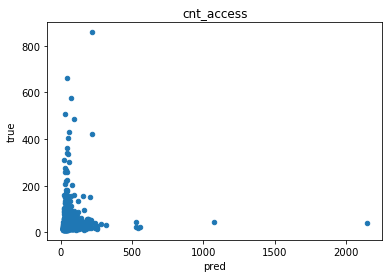

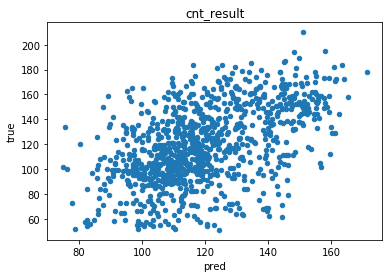

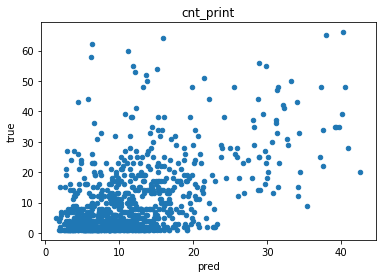

In [10]:
#3つの目的変数の学習モデルを構築する
%matplotlib inline
for i in range(3):

    #8割のデータを使って学習（残り２割のデータはモデルの妥当性検証に使う）
    p = 0.8

    #乱数種の設定
    np.random.seed=0
    
    #目的変数の設定
    target=df.columns[i]

    #学習用データと検証用データのインデックスを選択
    lnindexList = np.random.choice(df.index, size=int(df.index.shape[0]*p), replace=False)
    vdindexList = df.index[df.index.isin(lnindexList)==False].values

    #ランダムフォレストモデルを構築
    rfr = RandomForestRegressor(n_jobs=2,
                                n_estimators=10,
                                )

    rfr.fit(pressvec.ix[df.ix[lnindexList, target].dropna().index].values, df.ix[lnindexList, target].dropna().values)

    #学習モデルを保存
    pickle.dump(rfr, open('pred_' + target + '_model.pkl', 'wb'), protocol=4)
    
    #精度検証
    result = pd.DataFrame(index=vdindexList, columns=['pred'], data=rfr.predict(pressvec.ix[vdindexList]))
    result['true'] = df.ix[vdindexList, target]

    result.plot.scatter(x='pred', y='true', title=target)
    print(target, 'RMSE', ((result['pred'] - result['true'])**2).mean()**0.5)
    print(target, 'RMSE', ((result['pred'] - result['true'])**2).mean()**0.5 / (result['true']**2).mean()**0.5)